In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.fftpack import fft, ifft
import pywt

In [7]:
df_pow = pd.read_pickle('/mnt/data-r6/ahilan/dataset/neoen/process/pow_inv-32-A_5min.pkl')
df_POA = pd.read_pickle('/mnt/data-r6/ahilan/dataset/neoen/process/poa_5min.pkl')
df_Tmod = pd.read_pickle('/mnt/data-r6/ahilan/dataset/neoen/process/tmod_5min.pkl')
df_met = pd.read_pickle('/mnt/data-r6/ahilan/dataset/neoen/process/met_5min.pkl')
df_T = df_met[['Temp','Timestamp']]
df_T = df_T.rename(columns={'Temp': 'Temp','Timestamp': 'time'})


df_inner = pd.merge(df_pow, df_POA, on='time', how='inner')
df_inner2 = pd.merge(df_inner, df_Tmod, on='time', how='inner')
df = pd.merge(df_inner2, df_T, on='time', how='inner')


df.set_index('time', inplace=True)
df = df.rename(columns={'power': 'Power','value_x': 'POA','value_y': 'Tmod' })

print(df.shape)

(113472, 4)


In [53]:
df = pd.read_pickle('/mnt/data-r6/ahilan/dataset/neoen/process/full_inv_pow_1min.pkl')


In [52]:
df.set_index('Timestamp',inplace=True)
print(df.shape)

KeyError: "None of ['Timestamp'] are in the columns"

In [30]:
# Define the morning hour range
start_hour = 6
end_hour = 21

# Filter rows based on morning hour range
df = df[(df.index.hour >= start_hour) & (df.index.hour < end_hour)]
print(df.shape)

(70920, 4)


(394,)
False
False


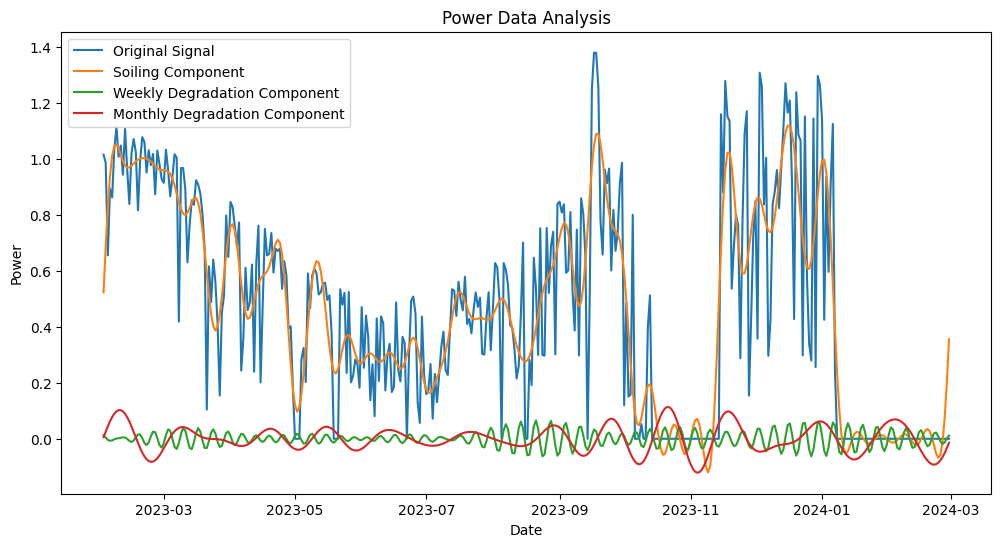

In [43]:
start_date = df.index.min()
end_date = df.index.max()

temp = df[start_date:end_date]['Power'].resample('D').mean()
print(temp.shape)

print(temp.isnull().any().any())
print(np.any(np.isinf(temp)))
temp_cleaned = temp.dropna()

data = temp_cleaned.values


# Fourier Transform
n = len(data)
t = np.linspace(0, 1, n)

# Fourier Transform
data_fft = fft(data)

frequencies = np.fft.fftfreq(len(temp))

# Identify low frequencies for soiling
low_freq_threshold = 0.1  # Example threshold for low frequencies
low_freq_indices = np.where(np.abs(frequencies) < low_freq_threshold)[0]

# Identify specific periodic components for performance degradation
# For example, identify components corresponding to weekly or monthly cycles
weekly_freq = 1/7  # Frequency for weekly cycle
monthly_freq = 1/30  # Frequency for monthly cycle

weekly_indices = np.where(np.abs(frequencies - weekly_freq) < 0.01)[0]
monthly_indices = np.where(np.abs(frequencies - monthly_freq) < 0.01)[0]

# Reconstruct the signal for soiling (low frequencies)
soiling_fft = np.zeros_like(data_fft)
soiling_fft[low_freq_indices] = data_fft[low_freq_indices]
soiling_signal = ifft(soiling_fft)

# Reconstruct the signal for weekly performance degradation
weekly_fft = np.zeros_like(data_fft)
weekly_fft[weekly_indices] = data_fft[weekly_indices]
weekly_signal = ifft(weekly_fft)

# Reconstruct the signal for monthly performance degradation
monthly_fft = np.zeros_like(data_fft)
monthly_fft[monthly_indices] = data_fft[monthly_indices]
monthly_signal = ifft(monthly_fft)

# Plot original signal
plt.figure(figsize=(12, 6))
plt.plot(temp.index, temp, label='Original Signal')

# Plot soiling component
plt.plot(temp.index, np.real(soiling_signal), label='Soiling Component')

# Plot weekly performance degradation component
plt.plot(temp.index, np.real(weekly_signal), label='Weekly Degradation Component')

# Plot monthly performance degradation component
plt.plot(temp.index, np.real(monthly_signal), label='Monthly Degradation Component')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Power')
plt.title('Power Data Analysis')
plt.show()

In [ ]:
'''
#Filtering cutailment period
# Define window size (number of hours in the sliding window)
window_size = 4

# Function to check if all values in the window are the same
def is_constant(window):
    return np.all(window == window[0])

# Identify curtailment periods using a rolling window
df['curtailment'] = df['Power'].rolling(window=window_size, min_periods=1).apply(is_constant)

# Convert rolling result to boolean (1.0 for curtailment, 0.0 for non-curtailment)
df['curtailment'] = df['curtailment'] == 1.0

# Filter out curtailment periods
df = df[~df['curtailment']]
print(df.shape)
'''

'''
df = df[df['POA']>100]
print(df.shape)
'''



'''
# Rolling statistics
window_size = 5
df['rolling_mean_POA'] = df['POA'].rolling(window=window_size, center=True).mean()
df['rolling_std_POA'] = df['POA'].rolling(window=window_size, center=True).std()

df['rolling_mean_Power'] = df['Power'].rolling(window=window_size, center=True).mean()
df['rolling_std_Power'] = df['Power'].rolling(window=window_size, center=True).std()

# Filtering outliers using IQA
# Calculate Q1 (25th percentile) and Q3 (75th percentile) for power output and irradiance
Q1_Power = df['Power'].quantile(0.25)
Q3_Power = df['Power'].quantile(0.75)
IQR_Power = Q3_Power - Q1_Power

Q1_POA = df['POA'].quantile(0.25)
Q3_POA = df['POA'].quantile(0.75)
IQR_POA = Q3_POA - Q1_POA

# Define lower and upper bounds for filtering
lower_bound_Power = Q1_Power - 1.5 * IQR_Power
upper_bound_Power = Q3_Power + 1.5 * IQR_Power

lower_bound_POA = Q1_POA - 1.5 * IQR_POA
upper_bound_POA = Q3_POA + 1.5 * IQR_POA

# Filter out data points outside the bounds
df = df[
    (df['Power'] >= lower_bound_Power) & (df['Power'] <= upper_bound_Power) &
    (df['POA'] >= lower_bound_POA) & (df['POA'] <= upper_bound_POA)
]

print(df.shape)
'''

# Identify outliers using roling mean
#deviation_threshold = 2  # 2 standard deviations
#df_filtered = df[
#    (df['Power'] >= df['rolling_mean_Power'] - deviation_threshold * df['rolling_std_Power']) &
#    (df['Power'] <= df['rolling_mean_Power'] + deviation_threshold * df['rolling_std_Power']) &
#    (df['POA'] >= df['rolling_mean_POA'] - deviation_threshold * df['rolling_std_POA']) &
#    (df['POA'] <= df['rolling_mean_POA'] + deviation_threshold * df['rolling_std_POA'])
#]
#
#print(df.shape)

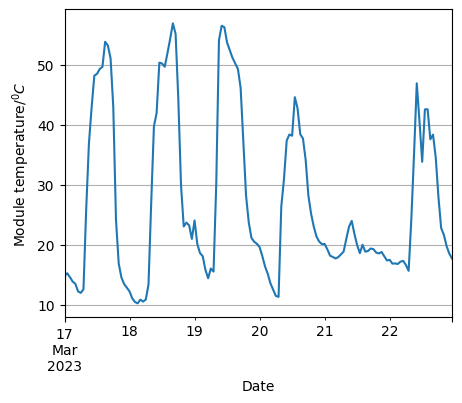

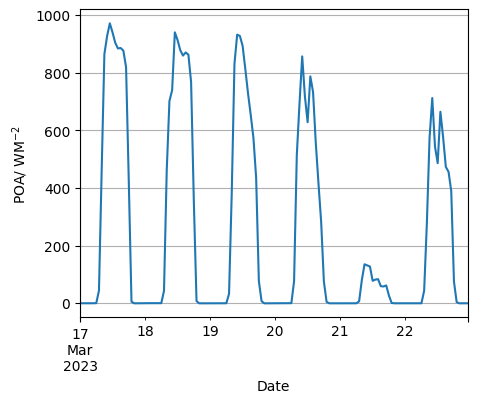

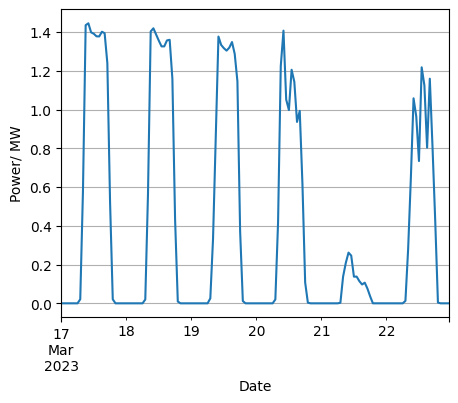

In [257]:
# Define the period you want to plot
start_date = '2023-03-17'
end_date = '2023-03-22'

# Slice the DataFrame based on the specified period
df_period = df[start_date:end_date]

df_period['Tmod'].resample('H').mean().plot(figsize=(5, 4))
plt.ylabel('Module temperature/$^{0}C$ ')
plt.xlabel('Date')
plt.grid(True)
plt.show()

df_period['POA'].resample('H').mean().plot(figsize=(5, 4))
plt.ylabel('POA/ WM$^{-2}$')
plt.xlabel('Date')
plt.grid(True)
plt.show()

df_period['Power'].resample('H').mean().plot(figsize=(5, 4))
plt.ylabel('Power/ MW')
plt.xlabel('Date')
plt.grid(True)
plt.show()


In [245]:
df.shape

(113472, 7)

In [246]:
df.describe()

,Power,POA,Tmod,Temp,PR_new,correction_cofficient,WCPR_new
count,113472.000000,113472.000000,113472.000000,113472.000000,1.067480e+05,113472.000000,1.067480e+05
mean,0.296731,233.306539,17.490338,15.354025,inf,1.000000,inf
std,0.513418,374.776575,16.046519,33.016471,NaN,0.072209,NaN
min,0.000000,-1.139593,-6.118014,0.000000,-1.765965e+04,0.893762,-1.870809e+04
25%,0.000000,-0.054264,4.311919,7.100000,-8.044287e-02,0.940697,-8.166335e-02
50%,0.000061,0.000000,13.214670,13.800000,0.000000e+00,0.980759,0.000000e+00
75%,0.408688,403.147500,28.085210,20.400000,9.056622e-01,1.047677,8.260385e-01
max,1.700452,1502.591000,68.853870,655.260000,inf,1.231136,inf


In [259]:
POA_std = 1000
#Each inverter each with an average of 5,700 modules for a 2 MW nominal maximum power input
#with output AC power limited to 1.7 MW

Capacity = 2.0

df['PR'] = (df['Power'] * POA_std) / (Capacity * df['POA'])

#T_std = 25 
T_avg = df['Tmod'].mean()
alpha = 0.004

df['correction_cofficient'] = (1 - alpha * (T_avg - df['Tmod']))
df['WCPR'] = df['PR']/df['correction_cofficient']




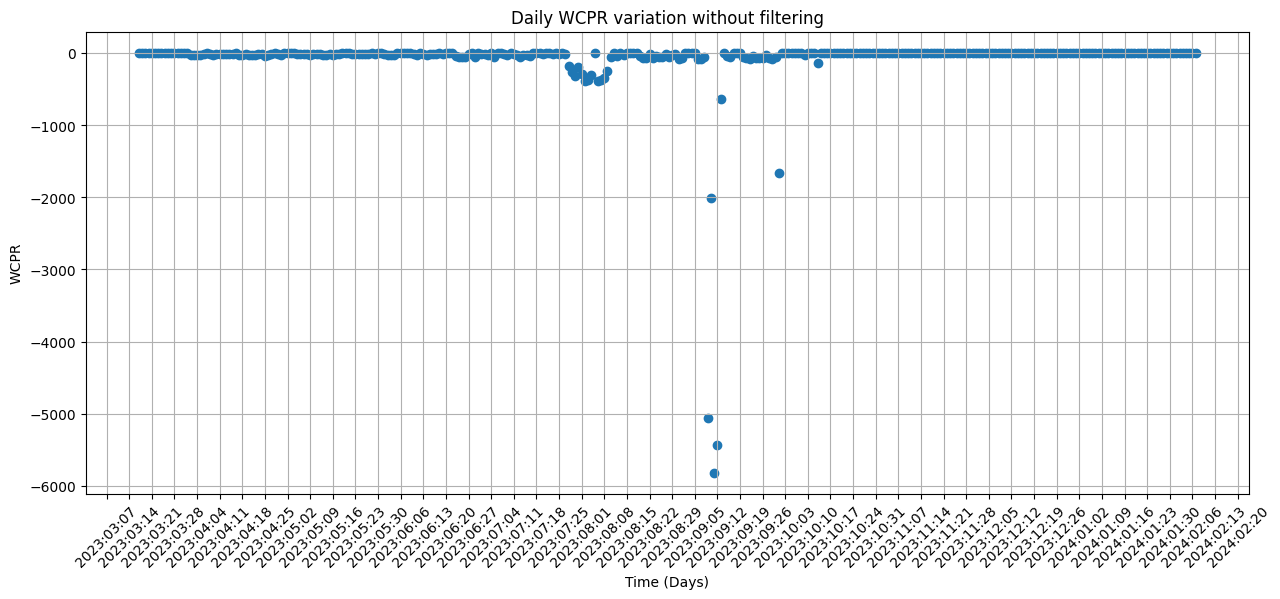

In [248]:
start_date = df.index.min()
end_date = df.index.max()

temp = df[start_date:end_date]['PR_new'].resample('D').mean()
plt.figure(figsize=(15, 6))
plt.scatter(temp.index.date, temp)

# Format x-axis to show every hour
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y:%m:%d'))
plt.title('Daily WCPR variation without filtering')
plt.xlabel('Time (Days)')
#plt.ylabel('Module temperature/$^{0}C$ ')
#plt.ylabel('Power/MW')
#plt.ylabel('POA/ WM$^{-2}$')
plt.ylabel('WCPR')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()

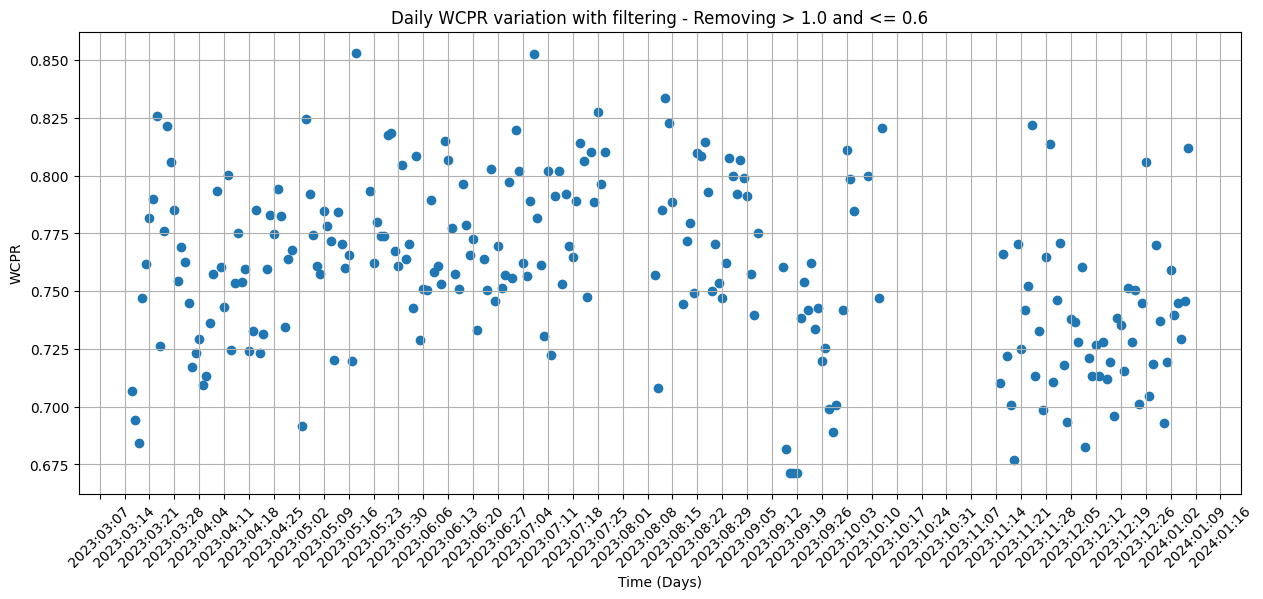

In [301]:
#PR and WCPR filtering
temp1 = df[df['WCPR'] > 0.6]
temp1 = temp1[temp1['WCPR'] <= 1.0]


start_date = df.index.min()
end_date = df.index.max()

temp = temp1[start_date:end_date]['WCPR'].resample('D').mean()
plt.figure(figsize=(15, 6))
plt.scatter(temp.index.date, temp)

# Format x-axis to show every hour
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y:%m:%d'))
plt.title('Daily WCPR variation with filtering - Removing > 1.0 and <= 0.6')
plt.xlabel('Time (Days)')
#plt.ylabel('Module temperature/$^{0}C$ ')
#plt.ylabel('Power/MW')
#plt.ylabel('POA/ WM$^{-2}$')
plt.ylabel('WCPR')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()


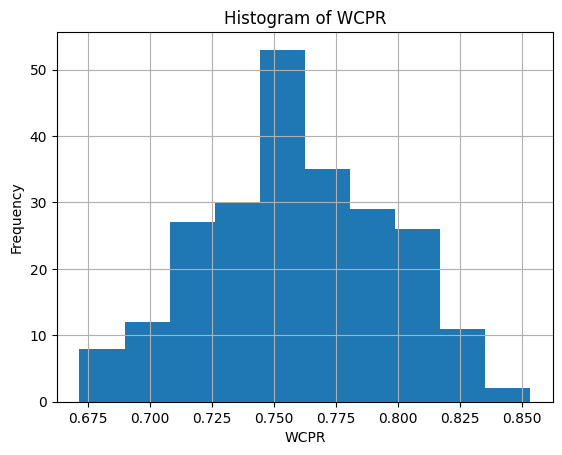

In [302]:
temp1['WCPR'].resample('D').mean().hist(bins=10)
plt.xlabel('WCPR')
plt.ylabel('Frequency')
plt.title('Histogram of WCPR')
plt.show()

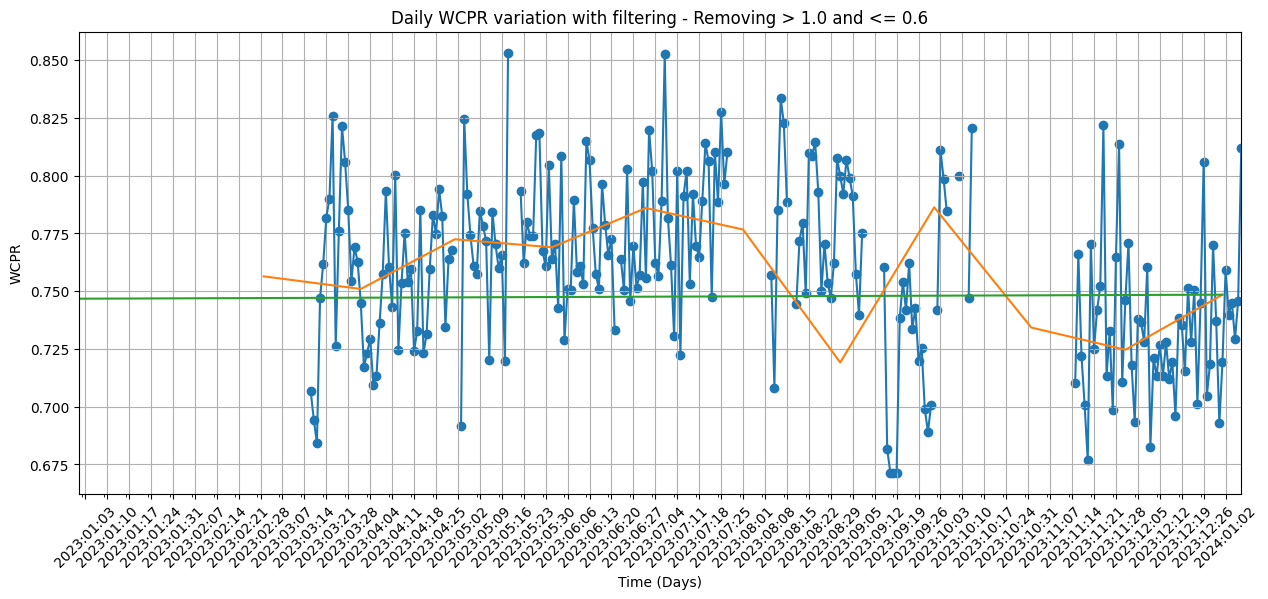

0.7476065046196909


In [303]:
#Ploting PR and WCPR over Daily, Monthly and Yearly

start_date = df.index.min()
end_date = df.index.max()

temp = temp1[start_date:end_date]['WCPR'].resample('D').mean()
plt.figure(figsize=(15, 6))
plt.scatter(temp.index.date, temp)

temp1['WCPR'].resample('D').mean().plot(figsize=(15, 6))
temp1['WCPR'].resample('M').mean().plot(figsize=(15, 6))
temp1['WCPR'].resample('Y').mean().plot(figsize=(15, 6))


# Format x-axis to show every hour
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y:%m:%d'))
plt.title('Daily WCPR variation with filtering - Removing > 1.0 and <= 0.6')
plt.xlabel('Time (Days)')
#plt.ylabel('Module temperature/$^{0}C$ ')
#plt.ylabel('Power/MW')
#plt.ylabel('POA/ WM$^{-2}$')
plt.ylabel('WCPR')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()
print(np.mean(temp1['WCPR'].resample('Y').mean()))

In [304]:
from statsmodels.tsa.stattools import adfuller
#PR and WCPR filtering
df = df[df['WCPR'] > 0.6]
df = df[df['WCPR'] <= 1.0]


# Decomposing the trend and seasonal variations
temp = df[start_date:end_date]['WCPR'].resample('H').mean()
print(temp.isnull().any().any())
print(np.any(np.isinf(temp)))
temp_cleaned = temp.dropna()



# Perform Augmented Dickey-Fuller test
result = adfuller(temp_cleaned)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

if result[1] < 0.05:
    print("\nThe time series is likely stationary (reject null hypothesis)")
else:
    print("\nThe time series is likely non-stationary (fail to reject null hypothesis)")

True
False
ADF Statistic: -6.170367168413948
p-value: 6.828585891810396e-08
Critical Values:
	1%: -3.4334842047036167
	5%: -2.8629245552811486
	10%: -2.5675070726005353

The time series is likely stationary (reject null hypothesis)


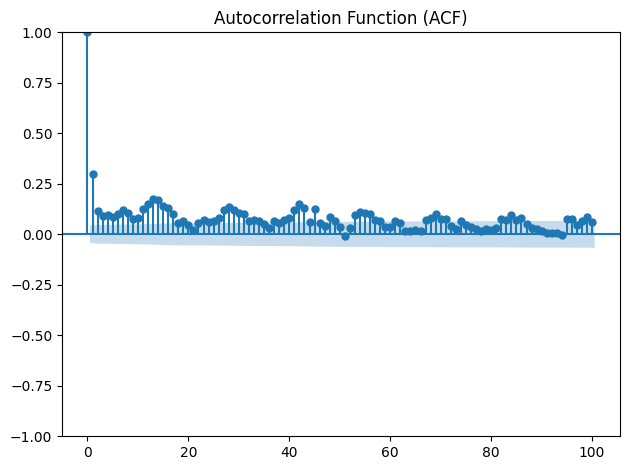

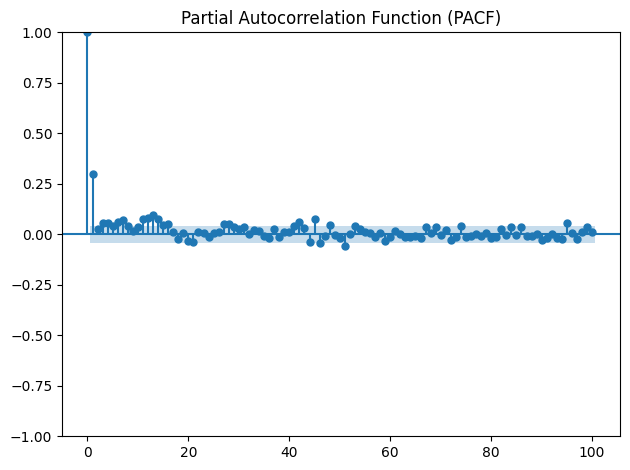

In [305]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# ACF plot
plot_acf(temp_cleaned, lags=100, alpha=0.05, title='Autocorrelation Function (ACF)')
plt.tight_layout()
plt.show()


# PACF plot
plot_pacf(temp_cleaned, lags=100, alpha=0.05, title='Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()




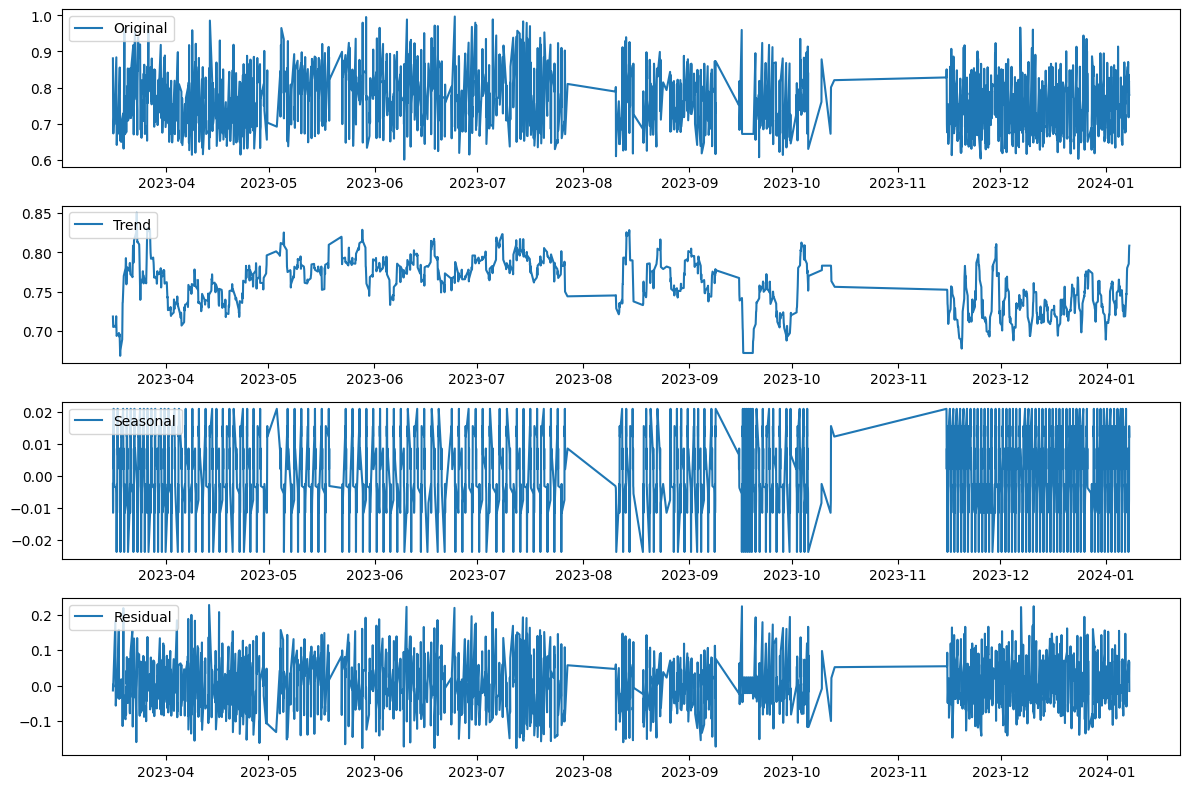

In [306]:
from statsmodels.tsa.seasonal import seasonal_decompose


# Decompose the time series into trend, seasonal, and residual components
decomposition = seasonal_decompose(temp_cleaned, model='additive', period=14)  # Assuming seasonality period of 30 (for example)

# Extract components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plotting the decomposed components
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(temp_cleaned, label='Original')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

(85649, 3)
True
False
(20520, 3)


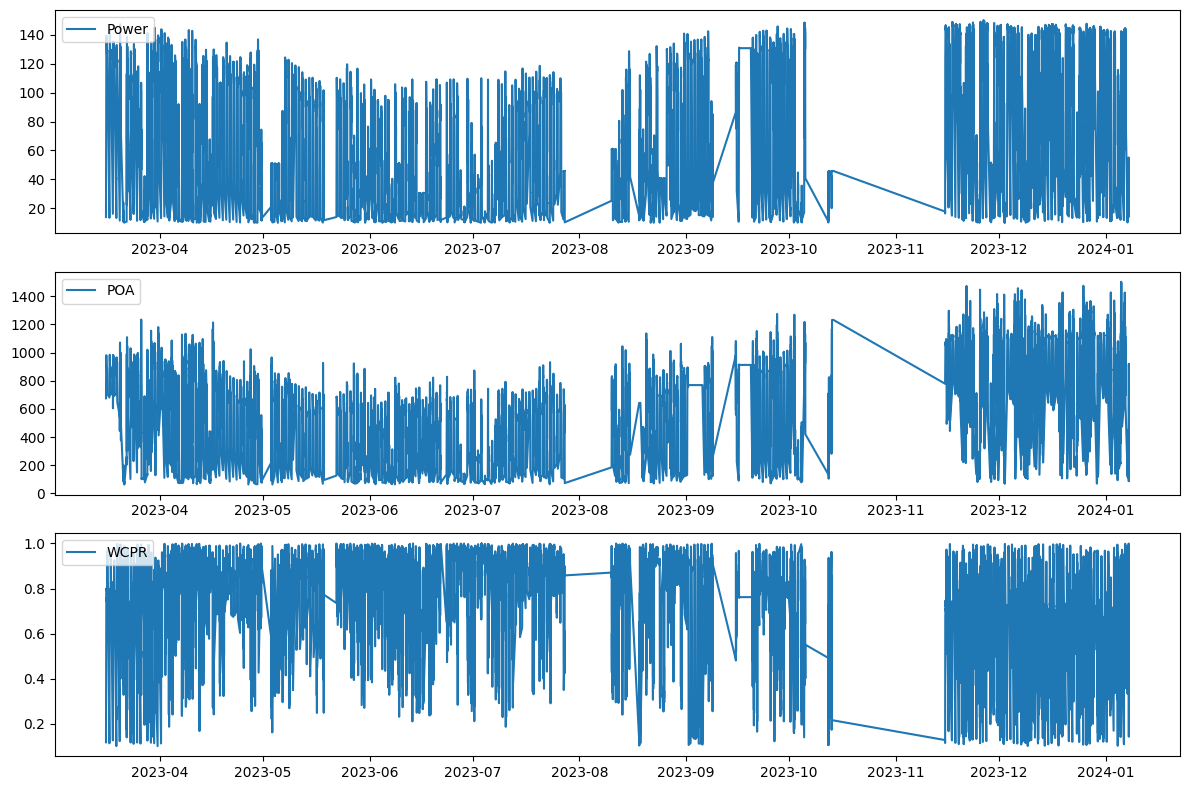

In [208]:
start_date = df.index.min()
end_date = df.index.max()

#start_date = '2023-08-01'
#end_date = '2023-08-08'

temp = temp4[start_date:end_date][['POA','Power','WCPR_new']].resample('5min').mean()

print(temp.shape)
print(temp.isnull().any().any())
print(np.any(np.isinf(temp)))
temp_cleaned = temp.dropna()

print(temp_cleaned.shape)

# Plotting the decomposed components
plt.figure(figsize=(12, 8))

plt.subplot(311)
plt.plot(temp_cleaned['Power'], label='Power')
plt.legend(loc='upper left')

plt.subplot(312)
plt.plot(temp_cleaned['POA'], label='POA')
plt.legend(loc='upper left')

plt.subplot(313)
plt.plot(temp_cleaned['WCPR_new'], label='WCPR')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

True
False
(2318,)
Shape of the sequences array: (2314, 5, 1)
Model: "model_83"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_49 (InputLayer)       [(None, 5, 1)]               0         []                            
                                                                                                  
 lstm_99 (LSTM)              (None, 128)                  66560     ['input_49[0][0]']            
                                                                                                  
 dense_194 (Dense)           (None, 128)                  16512     ['lstm_99[0][0]']             
                                                                                                  
 dense_195 (Dense)           (None, 2)                    258       ['dense_194[0][0]']           
                             

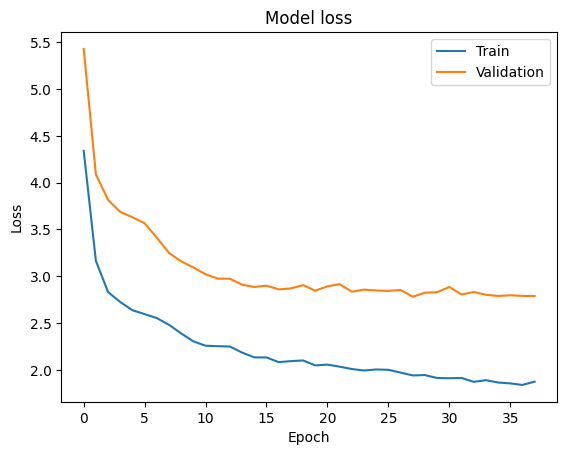

73/73 [==============================] - 1s 5ms/step


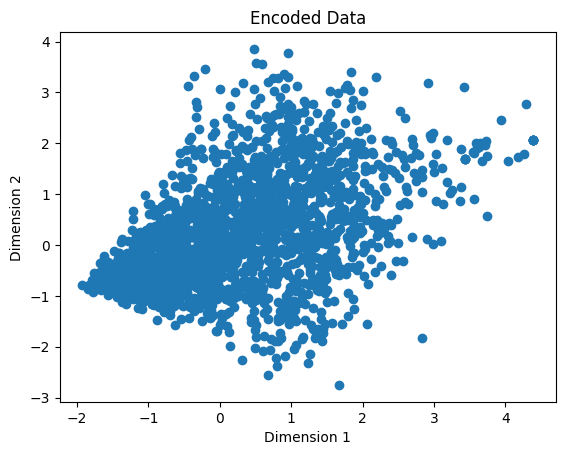

In [276]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K
from keras.optimizers import Adam

# Example: Generate synthetic time series data (replace with your own data loading)
np.random.seed(42)

temp = temp4[start_date:end_date]['WCPR_new'].resample('H').mean()
print(temp.isnull().any().any())
print(np.any(np.isinf(temp)))
temp_cleaned = temp.dropna()

data = temp_cleaned.values
print(data.shape)

# Normalize the data
data_mean = np.mean(data)
data_std = np.std(data)
data_normalized = (data - data_mean) / data_std

# Create sequences/windows
timesteps = 5 # Length of each sequence/window
num_sequences = len(data_normalized) - timesteps + 1

# Initialize an array to hold the sequences
sequences = np.zeros((num_sequences, timesteps, 1))

for i in range(num_sequences):
    sequences[i] = data_normalized[i:i + timesteps].reshape(-1, 1)

# Print the shape of the resulting three-dimensional array
print("Shape of the sequences array:", sequences.shape)


## Example: Split into training and testing data (optional)
train_size = int(0.8 * num_sequences)
train_sequences = sequences[:train_size]
test_sequences = sequences[train_size:]


# Function to sample from the latent space
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Hyperparameters
input_dim = 1   # Dimensionality of the input data
latent_dim = 2  # Dimensionality of the latent space
intermediate_dim = 128
dropout_rate = 0.2

# Encoder
inputs = Input(shape=(timesteps, input_dim))
h = LSTM(intermediate_dim, return_sequences=False,dropout=dropout_rate, recurrent_dropout=dropout_rate)(inputs)
h = Dense(intermediate_dim, activation='relu')(h)

z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_repeat = RepeatVector(timesteps)
decoder_lstm = LSTM(intermediate_dim, return_sequences=True, dropout=dropout_rate, recurrent_dropout=dropout_rate)
decoder_output = TimeDistributed(Dense(input_dim))


h_decoded = decoder_repeat(z)
x_decoded_mean = decoder_lstm(h_decoded)
x_decoded_mean = decoder_output(x_decoded_mean)


# VAE model
vae = Model(inputs, x_decoded_mean)

# Loss function
reconstruction_loss = mse(K.flatten(inputs), K.flatten(x_decoded_mean))
reconstruction_loss *= timesteps * input_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + 0.15*kl_loss)
vae.add_loss(vae_loss)

# Compile model
#vae.compile(optimizer='rmsprop')
optimizer = Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)
vae.summary()

X_train = sequences

# Train the VAE
#vae.fit(X_train, X_train, epochs=100, batch_size=32, validation_split=0.2)


# Train the VAE with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = vae.fit(X_train, epochs=200, batch_size=64, validation_split=0.2, callbacks=[early_stopping])


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Encode and decode some data points
encoder = Model(inputs, z_mean)
encoded_data = encoder.predict(X_train)

# Display some of the encoded data
plt.scatter(encoded_data[:, 0], encoded_data[:, 1])
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("Encoded Data")
plt.show()


# Extract latent representations and reconstructed sequences
#reconstructed_sequences = vae.predict(X_train)

73/73 [==============================] - 1s 5ms/step


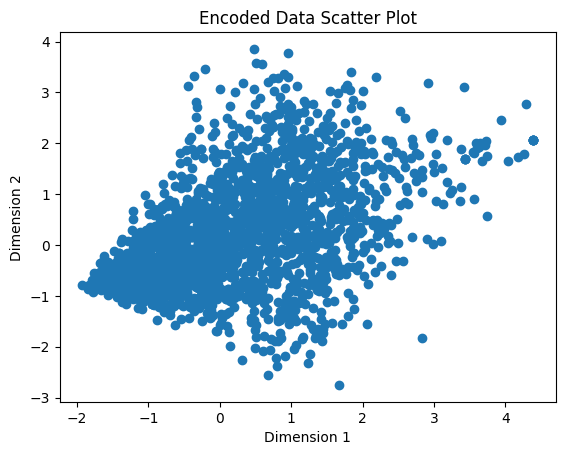

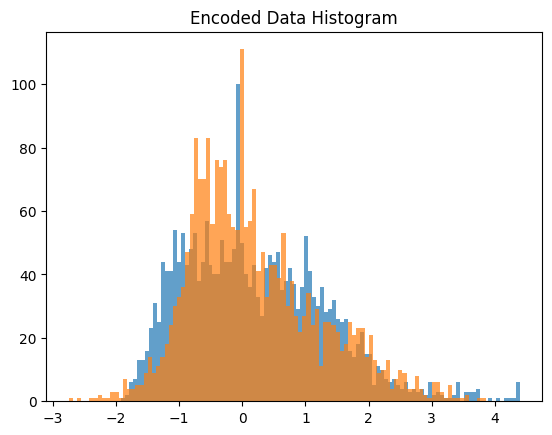

73/73 [==============================] - 2s 8ms/step


In [277]:
# Encode and decode some data points
encoder = Model(inputs, z_mean)
encoded_data = encoder.predict(X_train)

# Display some of the encoded data
plt.scatter(encoded_data[:, 0], encoded_data[:, 1])
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("Encoded Data Scatter Plot")
plt.show()

plt.hist(encoded_data[:, 0], bins=100, alpha=0.7, label='Feature 1')
plt.hist(encoded_data[:, 1], bins=100, alpha=0.7, label='Feature 2')
plt.title("Encoded Data Histogram")
plt.show()

# Extract latent representations and reconstructed sequences
reconstructed_sequences = vae.predict(X_train)

(2318, 1)
(2318, 1)


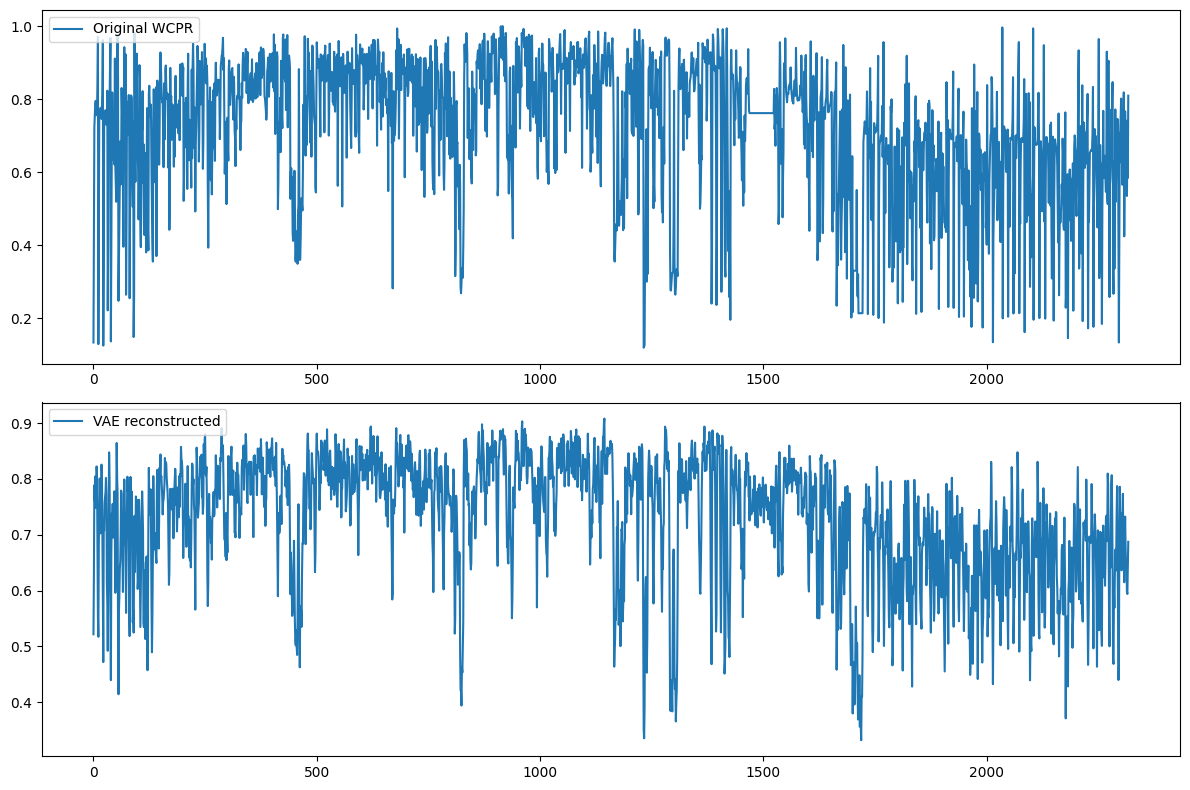

In [278]:
# Plot original vs. reconstructed time series
#(reconstructed_sequences * data_std) + data_mean

# 1. Reshape sequences back to original form
original_shape = (len(data_normalized), 1)
reconstructed_original_data = np.zeros(original_shape)
reconstructed_vae_data = np.zeros(original_shape)

for i in range(num_sequences):
    reconstructed_original_data[i:i + timesteps] = sequences[i]
    reconstructed_vae_data[i:i + timesteps] = reconstructed_sequences[i]


reconstructed_original_data_no_norm = (reconstructed_original_data * data_std) + data_mean
reconstructed_vae_data_no_norm = (reconstructed_vae_data * data_std) + data_mean

print(reconstructed_original_data_no_norm.shape)
print(reconstructed_vae_data_no_norm.shape)

temp_cleaned['original'] = reconstructed_original_data_no_norm
temp_cleaned['vae_constructed'] = reconstructed_vae_data_no_norm


# Plotting the decomposed components
plt.figure(figsize=(12, 8))

plt.subplot(211)
plt.plot(temp_cleaned['original'], label='Original WCPR')
plt.legend(loc='upper left')

plt.subplot(212)
plt.plot(temp_cleaned['vae_constructed'], label='VAE reconstructed')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()